# Maximum Likelihood vs. Integrating Over Hyperparameters

The default Bayesian Optimization maximize behavior uses `scikit-learn`'s `GaussianProcess` object to set the length scales of the covariance function via maximum likelihood. Integrating over the hyperparameters is an alternative approach where the length scales of the covariance function, in addition to the target mean, signal variance, and process noise, are sampled. The acquisition function then becomes an average across all hyperparameter settings. This alternative approach can be utilized by setting the parameter `integrateOverHypers` to `True` in the call to `maximize`.

In [12]:
# Import local version of the bayes_opt module
from os.path import dirname, realpath, sep, pardir
import sys
sys.path.append(dirname(realpath('__file__')) + sep + pardir)
from bayes_opt import BayesianOptimization

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import cPickle as pickle

%matplotlib inline

sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)
sns.set_style("darkgrid")
cmap = 'viridis'

## Simple Test Function to Optimize
$$ f(x,y) = -x^2 - (y-1)^2 + 1$$

Whose maximum of 1 is located at $(x,y)=(0,1)$

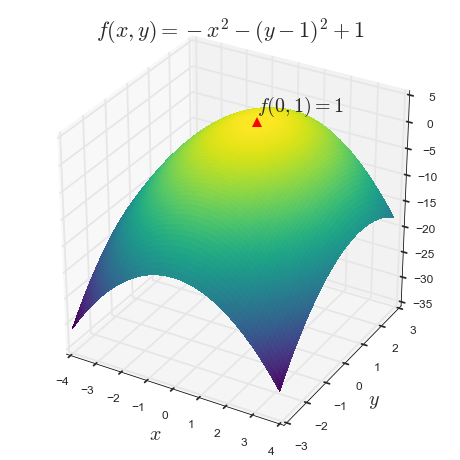

In [13]:
def func(x,y):
    return -x**2 - (y - 1)**2 + 1

bounds = {'x': (-4,4), 'y': (-3,3)}
xx, yy = np.meshgrid(np.arange(-4,4,0.1), np.arange(-3,3,0.1), sparse=True)

with sns.axes_style("white"):
    fig = plt.figure(figsize=((8,8)))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xx,yy,func(xx,yy), cmap=cmap, 
                    rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.plot([0],[1],[1], marker='^', markersize=10, markerfacecolor='r')
    ax.text(0,1,3,'$f(0,1)=1$', None, fontsize=20)
    plt.title('$f(x,y)=-x^2-(y-1)^2+1$', fontsize=22)
    plt.xlabel('$x$', fontsize=20, labelpad = 10)
    plt.ylabel('$y$', fontsize=20, labelpad = 10)

## Perform Bayesian Optimizations

Repition of this experiment is carried out in order to better compare the two approaches since there is randomness involved.

In [14]:
run = False

if run:
    n_repititions = 10
    n_iter = 50
    init_points = 2
    bo_ML_list = []
    bo_int_list = []

    for i in xrange(n_repititions):
        random_state = np.random.get_state()
        bo_ML = BayesianOptimization(func, bounds, verbose=0)
        bo_ML.maximize(init_points=init_points, n_iter=n_iter)
        bo_ML_list.append(bo_ML.res)

        # Ensure the two approaches start from the same random number generator state
        np.random.set_state(random_state)
        bo_int = BayesianOptimization(func, bounds, verbose=0)
        bo_int.maximize(init_points=init_points, n_iter=n_iter, integrateOverHypers=True)
        bo_int_list.append(bo_int.res)
    
    # Store the results since this will take a long time to run
    fi = open("comparison_results.p", "w")
    pickle.dump(bo_ML_list, fi)
    pickle.dump(bo_int_list,fi)
    fi.close()

## Aggregate Results
### Load Stored Results If BayesianOptimization Was Not Run

In [15]:
if not run:
    fi = open("comparison_results.p", "r")
    bo_ML_list = pickle.load(fi)
    bo_int_list = pickle.load(fi)
    fi.close()
    
    n_repititions = len(bo_ML_list)
    n_iter = len(bo_ML_list[0]['all']['values'])

In [16]:
def best_so_far(bo_list):
    """ 
    Generate arrays containing the mean and standard deviation of the best target value found as a function of iteration. 
    Useful for plotting performance results.
    
    Parameters
    ----------
    bo_list : list of BayesianOptimization.res dicts
    
    Returns
    -------
    mean : ndarray, shape (n_iter,)
        mean (across each Bayesian Optimiztion) of the best target value found as a function of iteration
    std : ndarray, shape (n_iter,)
        standard deviation (across each Bayesian Optimization) of the best target value found as a function of iteration
    """
    results = np.zeros((len(bo_list), len(bo_list[0]['all']['values'])))
    for rep in xrange(len(bo_list)):
        bestSoFar = -np.inf
        for it in xrange(n_iter):
            val = bo_list[rep]['all']['values'][it]
            if val > bestSoFar:
                results[rep, it] = val
                bestSoFar = val
            else:
                results[rep, it] = bestSoFar
                
    return np.mean(results, axis=0), np.std(results, axis=0)

In [17]:
int_mean, int_std = best_so_far(bo_int_list)
ML_mean, ML_std = best_so_far(bo_ML_list)

In [18]:
# fi = open("comparison_results (old best).p", "r")
# bo_ML_list = pickle.load(fi)
# bo_int_list = pickle.load(fi)
# fi.close()

# n_repititions_old = len(bo_ML_list)
# n_iter_old = len(bo_int_list[0]['all']['values'])

# ML_mean_old, ML_std_old = best_so_far(bo_ML_list, n_iter_old)
# int_mean_old, int_std_old = best_so_far(bo_int_list, n_iter_old)

## Plot Comparison

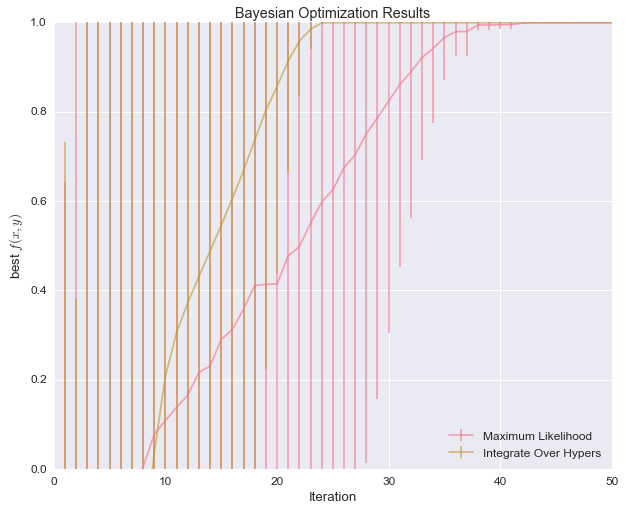

In [19]:
fig, ax = plt.subplots(**{'figsize':(10,8)})
ax.errorbar(range(1,n_iter+1), ML_mean, yerr=ML_std, label='Maximum Likelihood', alpha=0.6)
ax.errorbar(range(1,n_iter+1), int_mean, yerr=int_std, label='Integrate Over Hypers', alpha=0.6)
# try:
#     ax.errorbar(range(1,n_iter+1), ML_mean_old[:n_iter], yerr=ML_std_old[:n_iter], label='Maximum Likelihood (OLD)')
#     ax.errorbar(range(1,n_iter+1), int_mean_old[:n_iter], yerr=int_std_old[:n_iter], label='Integrate Over Hypers (OLD)')
# except:
#     pass
ax.set_ylim([0,1])
plt.title('Bayesian Optimization Results')
plt.xlabel('Iteration')
plt.ylabel('best $f(x,y)$')
ax.legend(loc='best')

## Conclusion

Based on the results, shown above, the Integrate Over Hypers approach reaches a fairly steady state, close to the maximum around iteration 9, on average. The default, Maximum Likelihood approach gets to a similar target value around iteration 50. There is a clear advantage in utilizing the Integrate Over Hypers approach since it optimizes the target function in fewer iterations.

Integrating over the Gaussian Process hyperparameters certainly adds overhead. On average, each iteration is about 30x slower than the default (Maximum Likelihood). This additional overhead would certainly be worth it, however, if evaluation of the target function were time consuming. Bayesian Optimization is particularly useful when the target function is costly and/or time consuming to evaluate. Thus, in most cases, integrating over hyperparameters should offer an advantage.

In [22]:
def best_so_far_nonagg(bo_list):
    """ 
    Generate arrays containing the mean and standard deviation of the best target value found as a function of iteration. 
    Useful for plotting performance results.
    
    Parameters
    ----------
    bo_list : list of BayesianOptimization.res dicts
    
    Returns
    -------
    mean : ndarray, shape (n_iter,)
        mean (across each Bayesian Optimiztion) of the best target value found as a function of iteration
    std : ndarray, shape (n_iter,)
        standard deviation (across each Bayesian Optimiztion) of the best target value found as a function of iteration
    """
    results = np.zeros((len(bo_list), len(bo_list[0]['all']['values'])))
    for rep in xrange(len(bo_list)):
        bestSoFar = -np.inf
        for it in xrange(n_iter):
            val = bo_list[rep]['all']['values'][it]
            if val > bestSoFar:
                results[rep, it] = val
                bestSoFar = val
            else:
                results[rep, it] = bestSoFar
                
    return results

(0, 1)

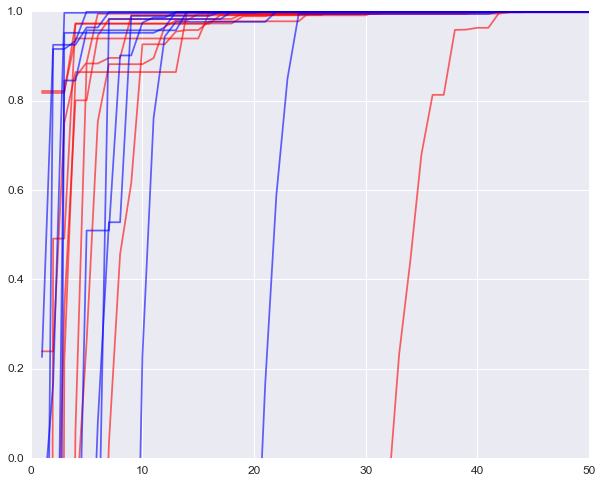

In [24]:
int_results = best_so_far_nonagg(bo_int_list)
ML_results = best_so_far_nonagg(bo_ML_list)
fig, ax = plt.subplots(**{'figsize':(10,8)})
ax.plot(range(1, n_iter+1), ML_results.T, color='r', alpha = 0.6)
ax.plot(range(1, n_iter+1), int_results.T, color='b', alpha = 0.6)
ax.set_ylim([0, 1])